In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping

# Phase 3 - stock volatility modeling

3 ML-based volatility models - LSTM, GRU, XGBoost
then evaluate them with different metrics such as MSE, RMSE, Log-likelihood, etc.

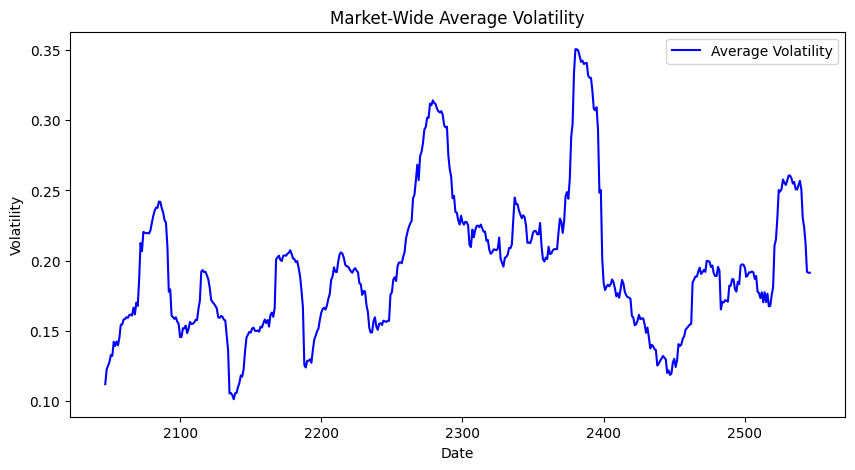

In [101]:
# gather data
stockgrp = pd.read_excel("10yrClosingPricesStocks.xlsx")
stockgrp = stockgrp.drop(columns=['Date'])

#volatility stuff
returns = np.log(stockgrp / stockgrp.shift(1))
volatility = returns.rolling(window=20).std() * np.sqrt(252)
volatility = volatility.dropna()

#we will work with the average of our 18 stocks to fit a marketwide view
avg_volatility = volatility.mean(axis=1) 
avg_volatility = avg_volatility.to_frame()

def plot_avg(data):
    plt.figure(figsize=(10,5))
    plt.plot(data, label="Average Volatility", color="blue")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.title("Market-Wide Average Volatility")
    plt.legend()
    plt.show()
plot_avg(avg_volatility.tail(500))

In [97]:
#Set up train and test data for LSTM and GRU models
train_size = int(len(avg_volatility) * 0.8)
train_data = avg_volatility[:train_size]
test_data = avg_volatility[train_size:]
train_data = train_data.values
test_data = test_data.values

# Initialize scalers
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data only
scaled_train_data = scaler.fit_transform(train_data.reshape(-1, 1))

# Transform the testing data using the same scaler
scaled_test_data = scaler.transform(test_data.reshape(-1, 1))

#create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30 #number of days to look back in a sequence - adjust this as needed
X_train, y_train = create_sequences(scaled_train_data, sequence_length)
X_test, y_test = create_sequences(scaled_test_data, sequence_length)

# Reshape X to include the feature dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
#build actual LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

#add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Train model
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

#Predict 
predictions = model.predict(X_test)


Epoch 1/50


c:\Users\Jack Klug\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0056 - val_loss: 5.5925e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010 - val_loss: 3.9993e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.5892e-04 - val_loss: 5.1605e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - val_loss: 3.7320e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.0536e-04 - val_loss: 3.1194e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.3655e-04 - val_loss: 3.4376e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.0505e-04 - val_loss: 2.3502e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.2174e-04 - val_loss: 2.6529e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6142e-04 - val_loss: 2.9075e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1635e-04 - val_loss: 3.4540e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.7037e-04 - val_loss: 2.5830e-0

RMSE: 0.009963077876237675
MAE: 0.006831768852627312
R²: 0.9596195528594871


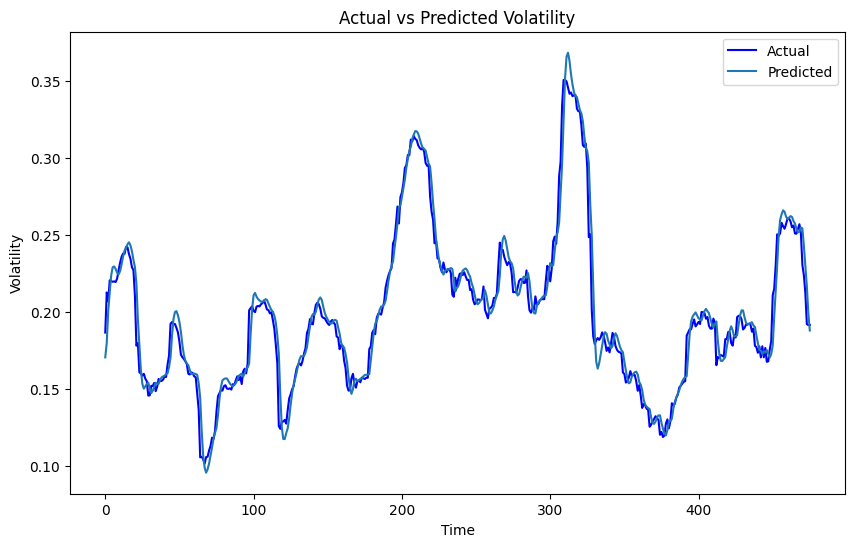

In [ ]:
#Evaluate LSTM Model
# this inverses the scaling from earlier
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions = scaler.inverse_transform(predictions) #rescale back to original values

#key metrics first
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, predictions)
print(f"MAE: {mae}")
r2 = r2_score(y_test_original, predictions)
print(f"R²: {r2}")

#Now visualize the model output/predictions
#actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## Summary of LSTM
Long short-term memory is a type of recurrent neural network especially good at handling time series data. It uses memory cells and gates to decide what information to keep, update, or forget. 

Let's look at how our model did:
- Above we have an excellent example of LSTM being used on our 18 stock dataset that basically perfectly predicts the volatility of our averaged stocks.
-  We can also see that our mean squared error and mean absolute error come out to less than .01, which is exceptional. 
- For the R^2 we were off of 1 by less than .05 meaning it was nearly a perfect fit to the actual data.
- Finally, we can then see all of these represented in our graph above showing almost the same graph for the actual and predicted volatilities

Now, let's try out the GRU model

In [99]:
#GRU model - we can use data from before and plug into model
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the GRU model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the GRU model
history = gru_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions
gru_predictions = gru_model.predict(X_test)

Epoch 1/50


c:\Users\Jack Klug\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0087 - val_loss: 2.8782e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.0340e-04 - val_loss: 4.2441e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - val_loss: 1.8568e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.0059e-04 - val_loss: 2.4113e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.9622e-04 - val_loss: 1.2867e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.5628e-04 - val_loss: 1.4203e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.4672e-04 - val_loss: 1.7634e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.4615e-04 - val_loss: 1.1531e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.5944e-04 - val_loss: 1.6994e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.1685e-04 - val_loss: 1.1030e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0406e-04 - val_loss: 1.065

GRU RMSE: 0.008028551479247654
GRU MAE: 0.00554851749888226
GRU R²: 0.9737784435673843


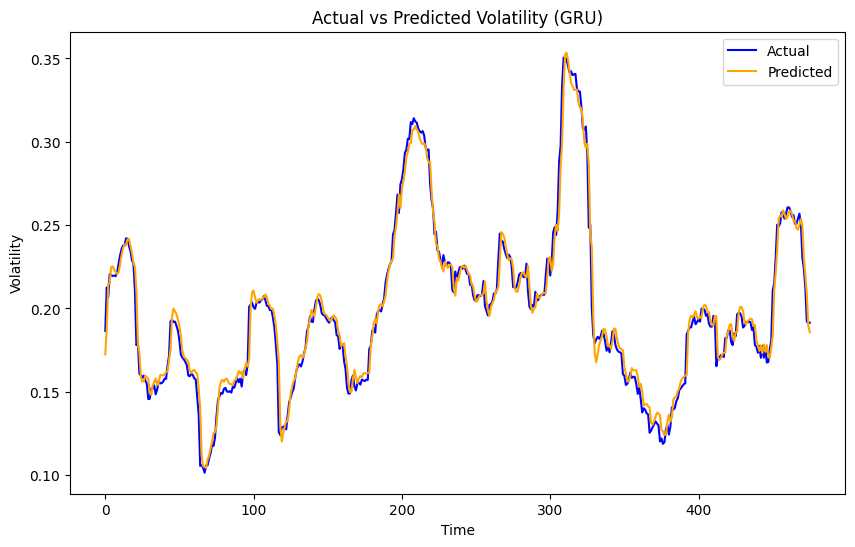

In [100]:
#Now evaluate performance metrics of the model and visualize the results
#start with rescaling data back to original scale
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions back to original values
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale y_test back to original values

#Now lets compute those performance metrics
rmse = np.sqrt(mean_squared_error(y_test_original, gru_predictions))
mae = mean_absolute_error(y_test_original, gru_predictions)
r2 = r2_score(y_test_original, gru_predictions)
print(f"GRU RMSE: {rmse}")
print(f"GRU MAE: {mae}")
print(f"GRU R²: {r2}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(gru_predictions, label='Predicted', color='orange')
plt.title('Actual vs Predicted Volatility (GRU)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## Summary of GRU
Gated Recurrent Unit is a type of recurrent neural network very similar to LSTM, but slightly simpler and with fewer parameters. It also uses gates to control how much information continues through, but has one less state.

Let's look at how our model did:
- GRU also works very well to predict volatility on our dataset
-  We can see that our mean squared error and mean absolute error come out to less than .01 and get even smaller values than LSTM got, which was already hard to beat
- The R^2 also somehow managed to get better and super close to 1 at 0.974
- Finally, we can then see all of these represented in our graph above showing almost the same graph for the actual and predicted volatilities

Now, let's try out the XGboost model